#### Notebook config

In [1]:
# %load ../../software/fullwavepy/fullwavepy/config/jupyter.py 
from arrau import *
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot', 'kmc_test'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(INFO) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


Suppress printing logs except warnings and errors:

In [8]:
lll(40)

Set the path for projects accessible by the computational cluster:

In [9]:
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano'

Load the experiment's metadata:

In [10]:
xp = PROTEUS()
xp.read_all()

##### Test the `fullwavepy.seismic.proteus` package

In [11]:
!python3 -m unittest fullwavepy.seismic.test.test_proteus  -v

test_local2geogr (fullwavepy.seismic.test.test_proteus.TestCoordSystemPROTEUS) ... ok
test_rotate_anticlock (fullwavepy.seismic.test.test_proteus.TestCoordSystemPROTEUS) ... ok
test_ (fullwavepy.seismic.test.test_proteus.TestPROTEUS) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


## Prepare acquistion

See `../ch07_Input_prep/Metadata.ipynb` for more.

#### Alg.
Read PROTEUS digital twin (old API). 

All ready-to-use data and metadata can be accessed as attributes of a `ProteusExperiment` object.

In [77]:
lll(40)
from fullwavepy.ioapi.proteus import ProteusExperiment
pro = ProteusExperiment()
lll(20)

In [86]:
pro.dataset['obshy']['101']

#### Alg.
Read bathymetry.

In [17]:
from arrau.a2d import Surf
fname = 'data/bathy_x-8e4_8e4_y_-4e4_4e4_res50_3201x1601.mmp'
arr = np.memmap(fname, dtype=np.float32, shape=(3201,1601))
bt = Surf(arr, extent=[[-8e4,8e4],[-4e4,4e4]])

#### Alg.
Read SEGY headers of PROTEUS dataset into a `Pandas` data frame.

In [8]:
fname = 'data/segy_headers.csv'
segy = pd.read_csv(fname)
segy.columns

Index(['level_0', 'cdpt', 'counit', 'day', 'delrt', 'dt', 'ep', 'f2', 'fldr',
       'gain', 'gelev', 'gwdep', 'gx', 'gy', 'hour', 'igc', 'index', 'laga',
       'minute', 'ns', 'ntr', 'offset', 'scalco', 'scalel', 'sdepth', 'sec',
       'selev', 'swdep', 'sx', 'sy', 'timbas', 'tracf', 'tracl', 'tracr',
       'trid', 'tstat', 'year'],
      dtype='object')

In [17]:
segy[['tracf','gx','gy','gelev','gwdep']].head(1)

,tracf,gx,gy,gelev,gwdep
0,1101,22644,17418,458,458.0


In [76]:
# segy[segy.tracf==4116] 

Three stations with no data (116, 152, 187) are not present in the dataset! Hence, they are not included in segy and consequently in the `recs.csv`! They were deployed though, thus they are present in `OBS_stations.csv`

In [110]:
segy.sample(10).loc[:, ['tracf', 'fldr']]

,tracf,fldr
149839,1109,26305
1216848,4168,25500
1202818,1168,25702
495499,1129,37415
302871,4119,18630
670921,4135,14115
969694,1157,14037
2794104,1822,31942
335831,4120,29112
427813,1126,11239


#### Alg.
Create `df` with only one component per station and a new column that stores a 3-digit station ID.

In [49]:
df = segy.loc[segy.tracf < 4000, :]
df.loc[:, 'id'] = df['tracf'].apply(str).str.slice(1).astype(int) # skip first char of tracf

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Alg.
Read info about shot lines.

In [ ]:
fname = 'data/shot_lines.csv'
shots = pd.read_csv(fname)
shots.columns

In [17]:
shots.drop(columns=['SOL (UTC)', 'Speed (knots)', 'Sequence', 'Adjustment to shot origin time (sec)'])

,Shot Line,Pattern,Start Shot,End Shot,Lat. 1st shot,Long. 1st shot,Lat. last shot,Long. last shot,Shot spacing (m),EOL (UTC),Duration (hrs),Other errors,Comment
0,1,P1,12243,12465,36.489291,24.889655,36.630716,25.259784,165,24/11/2015 21:37,5.6,NaN,NaN
1,2,P1,11506,11763,36.623392,25.331915,36.459331,24.904271,165,24/11/2015 15:32,6.5,NaN,NaN
2,3,P1,10977,11309,36.408521,24.864957,36.622516,25.416141,165,24/11/2015 07:08,8.5,NaN,NaN
3,4,P1,9882,10503,36.782898,25.929588,36.382030,24.898195,165,23/11/2015 21:29,16.0,apparent shot origin time errors that have not...,34 Missing shots 1038-1071
4,5,P1,17234,17865,36.331531,24.862271,36.739036,25.909569,165,27/11/2015 10:36,16.0,NaN,NaN
5,6,P1,21841,22536,36.711959,25.928787,36.266924,24.773713,165,29/11/2015 15:44,18.2,NaN,NaN
6,7,P1,24113,24428,36.488872,25.440646,36.692456,25.963698,165,30/11/2015 09:38,8.0,NaN,NaN
7,8,P1,21024,21336,36.470143,25.458405,36.669042,25.977707,165,28/11/2015 20:45,7.9,NaN,NaN
8,9,P1,20202,20511,36.648539,25.984308,36.452972,25.468434,165,28/11/2015 12:36,7.9,NaN,NaN
9,10,P1,19387,19688,36.431004,25.501705,36.627136,25.999987,165,28/11/2015 04:11,7.6,NaN,NaN


#### Alg.
Read info about OBS stations.

In [6]:
fname = 'data/OBS_stations.csv'
obs = pd.read_csv(fname, encoding='latin')
obs.columns

Index(['Station', 'Pool', 'Data logger', 'Bad VZ', 'Bad HY', '6Hz-Z',
       'Preferred', 'HZ RMS', 'HZ noise', 'VZ/HY signal', 'Comment (CP 2017)',
       'Comment (EH 2016)', 'Eval'],
      dtype='object')

In [31]:
obs

,Station,Pool,Data logger,Bad VZ,Bad HY,6Hz-Z,Preferred,HZ RMS,HZ noise,VZ/HY signal,Comment (CP 2017),Comment (EH 2016),Eval
0,101,SIO,SP,NaN,NaN,XXX,NaN,7.96,15.28,1.92,HYD prearrival noise ~x2 compared to Z. A LOT ...,NaN,OK
1,102,SIO,SP,NaN,NaN,XXX,NaN,6.14,10.34,1.68,Similar noise. Z with a lot of 6Hz noise. HYD ...,NaN,OK
2,103,WHOI,NaN,NaN,NaN,NaN,NaN,0.85,1.98,2.32,HYD prearrival noise ~x2 compared to Z.,attenuation from -5 km to west,OK
3,104,SIO,SP,NaN,NaN,X,NaN,7.24,12.26,1.69,"Low f noise in Z (sometimes at ~6Hz, not alway...",NaN,OK
4,105,WHOI,NaN,NaN,NaN,NaN,NaN,0.70,1.72,2.44,HYD prearrival noise ~x2 compared to Z. Prefer Z,NaN,OK
5,106,SIO,SP,NaN,NaN,XX,NaN,8.59,14.61,1.70,"Low f noise in Z (stongly at ~6Hz, not always)...",NaN,OK
6,107,SIO,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bad data,BAD - data cut issue?,Not picked
7,108,WHOI,NaN,NaN,NaN,NaN,NaN,0.65,0.97,1.50,"HYD/Z same quality, same noise",NaN,OK
8,109,SIO,13,X,NaN,NaN,HYD,392.49,70.71,0.18,"Z has anomaloysly low-count level (x20 times),...",NaN,OK
9,110,WHOI,NaN,NaN,NaN,NaN,NaN,0.81,1.10,1.36,Z slightly better pre-arrival noise than HYD,attenuation from -5 km to west,OK


#### Alg.
Read info about land stations.

In [7]:
fname = 'data/land_stations.csv'
land = pd.read_csv(fname, encoding='latin')
land.columns

Index(['site number', 'Location', 'type', 'long', 'lat', 'elev', 'seismo',
       'receiver', 'disk', 'GPS', 'comments', 'CRP Channel#'],
      dtype='object')

In [34]:
land

,site number,Location,type,long,lat,elev,seismo,receiver,disk,GPS,comments,CRP Channel#
0,801,SC Thera,bed rock,25.45151,36.36696,361,1189,3073,1067,Internal,NaN,1
1,802,SC Thera,dug hard,25.43982,36.37341,187,1349,3093,1087,Internal,NaN,4
2,803,C Thera,bed rock,25.43474,36.39148,64,2829,3123,1125,Internal,Orientation 2 deg to west,7
3,804,S Thera,bed rock,25.44439,36.34175,79,1329,3078,1072,External,Elevation may be off,10
4,805,SC Thera,dug soft,25.42263,36.36892,154,1877,3109,1100,Internal,Orientation 8 deg to west,13
5,806,SW Thera,inside church,25.41954,36.35618,90,1817,3100,1090,External,NaN,16
6,808,N Thera,dug hard,25.38665,36.47567,31,1875,3107,1098,Internal,Orientation 10 deg to west,19
7,809,N Thera,cement on rock,25.42113,36.46096,128,1886,3110,1101,Internal,NaN,22
8,810,N Thera,on concrete,25.45073,36.43181,46,1348,3092,1086,Internal,NaN,25
9,811,N Thera,bed rock?,25.41956,36.43243,247,1829,3103,1093,Internal,NaN,28


#### Alg.
Extract xy coordinates of all sources and save to `csv`.

In [50]:
sxy = df.drop_duplicates(subset=['fldr'], keep='first').loc[:, ['fldr', 'sx', 'sy']]

In [54]:
fname = 'data/srcs.csv'
sxy.to_csv(fname)

#### Alg.
Extract xy coordinates of all receivers.

In [11]:
rxy = df.drop_duplicates(subset=['tracf'], keep='first').loc[:, ['id', 'gx', 'gy']]

#### Alg.
Create an `id -> pool` mapping.

In [12]:
pool_obs = dict(zip(obs.Station, obs.Pool)) # NOTE create 
pool_lan = dict(zip(land['site number'], ['land']*len(land)))
pool = {**pool_obs, **pool_lan}

#### Alg.
Create a dataframe with all receiver data needed for plots.

In [43]:
recs = rxy
recs.loc[:, 'pool'] = recs['id'].apply(lambda key : pool[key])
recs = recs.sort_values('id')

In [14]:
# no. of stastions per pool
recs[recs.pool == 'SIO'].shape[0], recs[recs.pool == 'WHOI'].shape[0], recs[recs.pool == 'land'].shape[0]

(58, 30, 31)

#### Alg.
Save `recs` to csv.

In [45]:
fname = 'data/recs.csv'
recs.to_csv(fname)

# Plot bathymetry

#### Fig.
Bathymetry in color with shading (oldish).

ratio 2.5
CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 87.8 ms


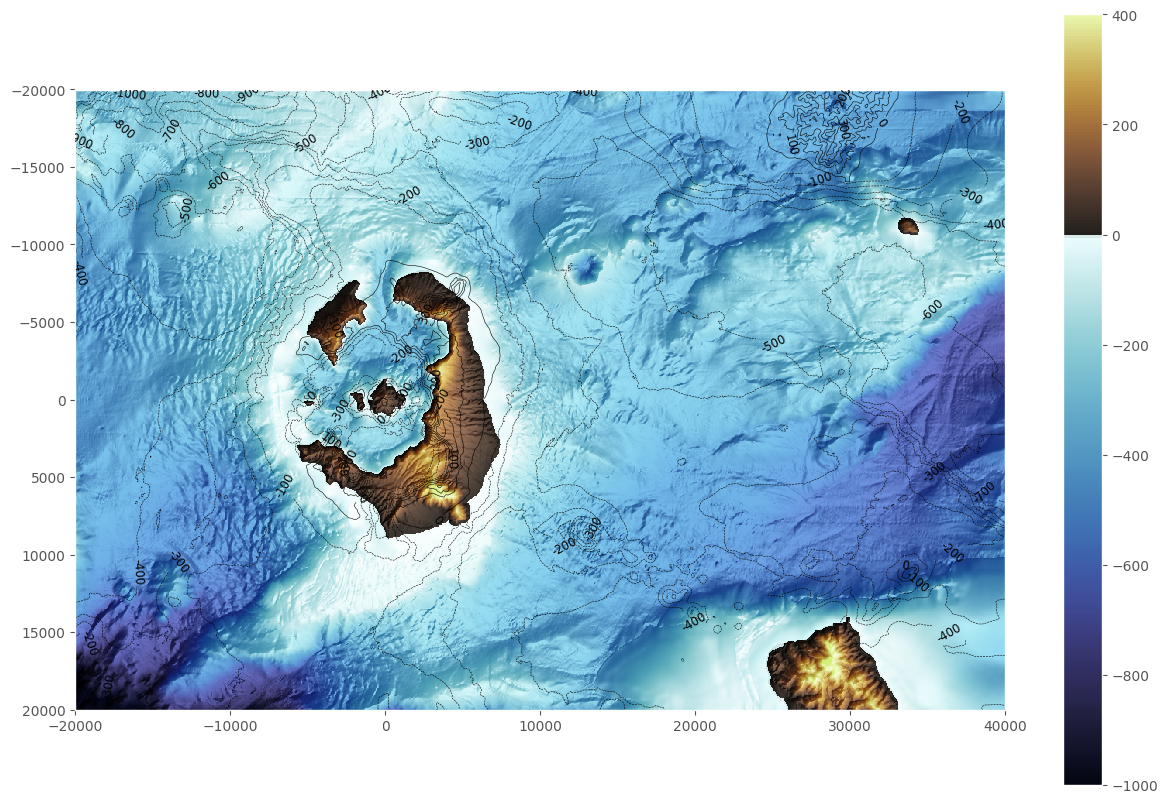

In [26]:
# plot 
from fullwavepy.plot.plt2d import cat_cmaps
x1, x2 = -2e4, 4e4
y1, y2 = -2e4, 2e4
extent=[x1,x2,y1,y2]
bt = -pro.bathytopo.carve(box=[x1,x2,y1,y2,0,0])[...,0]
figure(15,10)
from matplotlib.colors import LogNorm, LightSource
from matplotlib.cm import ScalarMappable
ls = LightSource(azdeg=45, altdeg=45)
vmin, vmax = -1000, 400
# cmap = _combine_2_cmaps(['cmo.turbid','cmo.ice_r'])
# cmap = cat_cmaps(['cmo.ice','copper'], 250, 100, )
cmap = cat_cmaps(['cmo.ice','cmo.turbid_r'], vmin, vmax) # these numbers results
%time image = ls.shade(bt.T, cmap=cmap, blend_mode='soft', vert_exag=1, vmin=vmin, vmax=vmax)
plt.imshow(image, extent=extent)
# cbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
# cntrs (VERY WEIRD EXTENT)
cntr = plt.contour(bt.T, extent=[x1,x2,y1,y2], colors='k', levels=20, linewidths=.4)
plt.gca().clabel(cntr, cntr.levels, fontsize='smaller', fmt='%1.0f')
# final
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

# Plot acquisiton

#### Tab.
Subdomains of particular interest.

In [6]:
from fullwavepy.seismic.misc import Box3d

In [7]:
# b01 
x1 = +8.0e3
x2 = +2.5e4   
y1 = -3.0e3   
y2 = +1.5e4    
z1 = 0
z2 = +4.0e3
b01 = Box3d(x1, x2, y1, y2, z1, z2)

In [8]:
# b02 
x1 = 0.8e4
x2 = 1.8e4
y1 = 0.4e4
y2 = 1.4e4
z1 = 0.0e4
z2 = 0.4e4
b02 = Box3d(x1, x2, y1, y2, z1, z2)

#### Fig.
Acquisition geometry + subdomains.

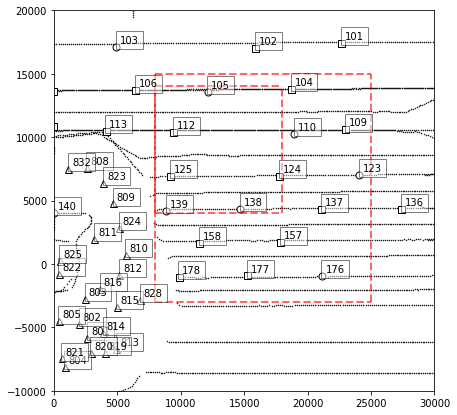

In [9]:
# plot 
xp = PROTEUS()
xp.plot_acq(bt=0, box=0, zoom=0)
xp._plot_box(b01.extent[:-1])
xp._plot_box(b02.extent[:-1])
plt.xlim(0,3e4)
plt.ylim(-1e4,2e4)
plt.show()

# Plot acquistion on top bathymetry

#### Fig. 
Acquisition geometry on top of the bathymetry.

In [1]:
from fullwavepy.seismic.proteus import PROTEUS
xp = PROTEUS()
xp.read_all()

(-8000.0, 10000.0)

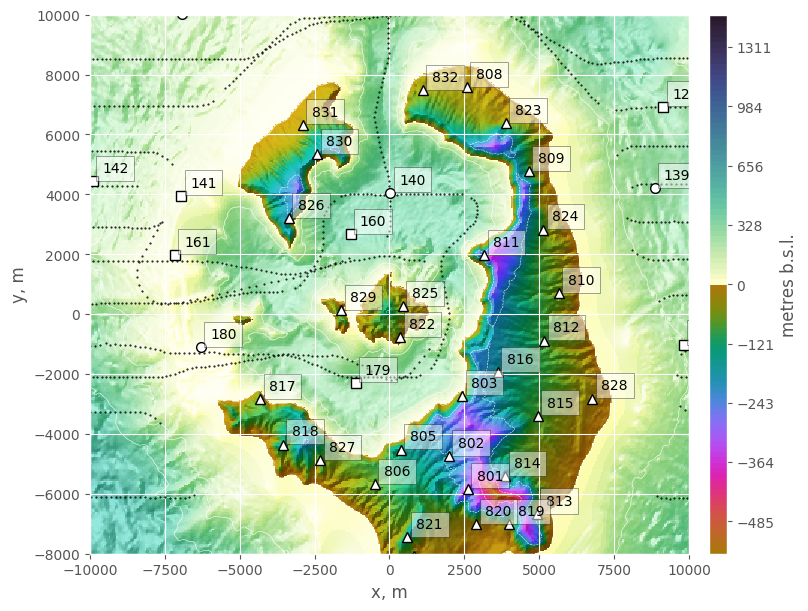

In [7]:
xp.plot_acq()
plt.xlim(-1e4,1e4)
plt.ylim(-8e3,1e4)

#### Fig. 
Acquisition geometry on top of the bathymetry inside a square Kolumbo box.

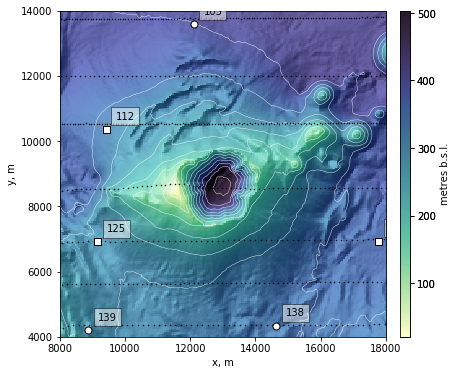

In [16]:
# plot 
x1 = 0.8e4
x2 = 1.8e4
y1 = 0.4e4
y2 = 1.4e4
z1 = 0.0e4
z2 = 0.4e4
extent = [[x1,x2],[y1,y2]]
bt_kol = bt.extract(extent)

figure(15,6)
bt_kol.plot()
bt_kol.plot(mode='shade', cmap='cmo.deep', label='metres b.s.l.')
bt_kol.plot(mode='cr', colors='w')
plot_acq_geom(srcs, recs, sio, who, lan)
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.show()

# ...